# Zweifeldträger Schulbeispiel

Das Vorlesungsbeispiel verfolgt das Ziel, die Verformungen eines Zweifeldträgers für zwei Betonstähle mit unterschiedlichen Duktilitätsklassen aufzuzeigen. @jager_stahlbeton_2009.

![Statisches System des Zweifeldträgers mit Abmessungen versehen, daneben der Querschnitt mit Angaben zu der Längsbewehrung](../imgs/zweifeld_system.png){#fig-zweifeld_system}

Zunächst wird die analytische Lösung vollumfänglich dargestellt und mit numerischen Werten substituiert. Abschliessend wird das Verformungsverhalten mit dem Federmodell nachmodelliert, bzw. numerisch approximiert.

## Annahmen

- Zwei unterschiedliche Stähle
- konstant gerissene Biegesteifigkeit entlang der Stabachse

In [1]:
from packages import *

In [2]:
diam_x = 14 * mm  # Längsbewehrung in X-Richtung gerichtet
s_x = 200 * mm  # Teilung der Längsbewehrung
diam_y = 12 * mm  # Längsbewehrung in Y-Richtung gerichtet
s_y = 200 * mm  # Teilung der Längsbewehrung

c = 20 * mm  # Betonüberdeckung
h = 300 * mm  # Plattenstärke
b_w = 1 * m  # Streifenbreite

d_x = h - c - diam_y - 1 / 2 * diam_x  # Statische Höhe in X-Richtung

put_out()

$$
\begin{aligned}
\oslash_{x} & = 14 \ \mathrm{mm} \quad & s_{x} & = 200 \ \mathrm{mm} \quad & \oslash_{y} & = 12 \ \mathrm{mm} \\ 
s_{y} & = 200 \ \mathrm{mm} \quad & c & = 20 \ \mathrm{mm} \quad & h & = 300 \ \mathrm{mm} \\ 
b_{w} & = 1 \ \mathrm{m} \quad & d_{x} & = 261.0 \ \mathrm{mm} \quad &  
 \end{aligned}
$$

## Kaltverformter Betonstahl B500A

### Eigenschaften des Betonstahls


In [3]:
f_sy = 570 * N / mm**2  # Fliessgrenze
f_su = 600 * N / mm**2  # Zugfestigkeit
epsilon_sy = 2.78 / 1000  # Fliessdehnung
epsilon_su = 25 / 1000  # Bruchdehnung
E_s = 205 * kN / mm**2  # Elastizitätsmodul
E_sh = 1350 * N / mm**2  # Verfestigungsmodul

put_out(precision=4)

$$
\begin{aligned}
f_{sy} & = 570.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{su} & = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \epsilon_{sy} & = 0.0028 \\ 
\epsilon_{su} & = 0.025 \quad & E_{s} & = 205.0 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \quad & E_{sh} & = 1350.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

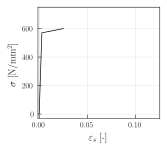

In [4]:
# | echo: false

stress_b500a_array = np.array([0, f_sy.magnitude, f_su.magnitude]) * MPa
strain_b500a_array = np.array([0, epsilon_sy, epsilon_su])


fig, ax = plt.subplots()

ax.plot(strain_b500a_array, stress_b500a_array.to(MPa).magnitude, color="k")


# Set axis labels
ax.set_ylabel(r"$\sigma$ [N/mm$^2$]")
ax.set_xlabel(r"$\varepsilon_s$ [-]")

# Set limits
ax.set_xlim(xmax=125 / 1000)
ax.set_ylim(ymax=750)

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig("imgs/stress_strain_b500a.svg")
plt.close()

![Spannungs-Dehnungs-Beziehung des Betonstahls B500A](../imgs/stress_strain_b500a.svg){#stress_strain_b500a}

### Eigenschaften des Betons

In [5]:
# Zylinderdruckfestigkeit vorausgesetzt
f_cc = 30 * N / mm**2

# Betonzugfestigkeit, nicht einheitentreu
f_ct = (0.3 * f_cc.magnitude ** (2 / 3)) * N / mm**2 

# Effektive Betondruckfestigkeit, nicht einheitentreu
f_c = (2.5 * f_cc.magnitude ** (2 / 3)) * N / mm**2 

# Elastizitätsmodul des Betons
E_c = 29.3*kN/mm**2

put_out()

$$
\begin{aligned}
f_{cc} & = 30.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{ct} & = 2.9 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{c} & = 24.14 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
E_{c} & = 29.3 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \quad &  \quad &  
 \end{aligned}
$$

### Linear elastische - gerissene Biegesteifigkeit

Querschnittsanalyse:


In [6]:
# Querschnittsfläche der Längsbewehrung, pro Längeneinheit
a_s = (diam_x**2 / 4 * np.pi / s_x).to(mm**2 / m)

# Wertigkeit der Elastizitätsmodule
n = E_s / E_c

put_out()

$$
\begin{aligned}
a_{s} & = 769.69 \ \frac{\mathrm{mm}^{2}}{\mathrm{m}} \quad & n & = 7.0 \  \end{aligned}
$$

Die Druckzonenhöhe wird mittels dem Gleichgewicht der horizontalen Kräfte ermittelt

In [7]:
# Mittels Sympy (CAS für Python) wird eine analytische Lösung der
# Druckzonenhöhe für den gerissenen Querschnitt ermittelt.

# Summe der horizontalen Kräfte
sum_Fx = sp.sympify("1/2*x*b_w*sigma_c -sigma_s*a_s*b_w")

# Definition der Spannung in Abhängigkeit der Dehnungen
expr_sigma_c = sp.sympify("varepsilon_c * E_c")
expr_sigma_s = sp.sympify("varepsilon_s * n * E_c")

# Die Beziehung zwischen der Stahl- und Betondehnung nach Hook
expr_epsilon_c = sp.sympify("varepsilon_s /(d-x)*x")

# Substitution der Gleichungen
sum_Fx_subs = sum_Fx.subs(
    {
        "sigma_c": expr_sigma_c.subs("varepsilon_c", expr_epsilon_c),
        "sigma_s": expr_sigma_s,
    }
)

# Erstellen einer numerischen Funktion
x_solve = sp.solve(sum_Fx_subs, "x")[1]
x_solve_lambd = sp.lambdify(("a_s", "b_w", "n", "d"), x_solve)

In [8]:
# Druckzonenhöhe mit Parametern substituiert
x = x_solve_lambd(a_s, b_w, n, d_x).to(mm)

# Flächenmoment 2. Grades für den gerissenen Querschnitt
I_cII = (b_w * x**3 / 12 + b_w * x * (x / 2) ** 2).to(mm**4)
I_sII = (a_s * b_w * n * (d_x - x) ** 2).to(mm**4)
I_II = (I_cII + I_sII).to(mm**4)

# Gerissene Biegesteifigkeit
EI_II = (E_c * I_II).to(kN * m**2)

put_out()

$$
\begin{aligned}
x & = 47.91 \ \mathrm{mm} \quad & I_{cII} & = 36650532.72 \ \mathrm{mm}^{4} \quad & I_{sII} & = 244534349.46 \ \mathrm{mm}^{4} \\ 
I_{II} & = 281184882.18 \ \mathrm{mm}^{4} \quad & EI_{II} & = 8238.72 \ \mathrm{kN} \cdot \mathrm{m}^{2} \quad &  
 \end{aligned}
$$

Damit ist die Biegesteifigkeit definiert.